In [2]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [3]:
# loading data
df = pd.read_csv('complaints.csv')

d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: DtypeWarning: Columns (9,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.shape

(3479257, 18)

In [5]:
df.head(3).T

,0,1,2
Date received,2021-10-12,2021-01-12,2023-01-24
Product,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."
Sub-product,Credit reporting,Credit reporting,Credit reporting
Issue,Problem with a credit reporting company's inve...,Incorrect information on your report,Problem with a credit reporting company's inve...
Sub-issue,Investigation took more than 30 days,Information belongs to someone else,Their investigation did not fix an error on yo...
Consumer complaint narrative,hi experian has a low and unfair credit number...,I disputed innacurate accounts reported by you...,I have continued to dispute this account with ...
Company public response,Company has responded to the consumer and the ...,Company has responded to the consumer and the ...,NaN
Company,Experian Information Solutions Inc.,"TRANSUNION INTERMEDIATE HOLDINGS, INC.","EQUIFAX, INC."
State,IL,IL,FL
ZIP code,60615.0,60615.0,33823.0


In [6]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

print(df1.shape)

df1.head(2).T

(1254126, 2)


,0,1
Product,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."
Consumer_complaint,hi experian has a low and unfair credit number...,I disputed innacurate accounts reported by you...


In [7]:
pd.DataFrame(df1.Product.unique()).values

array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Mortgage'],
       ['Debt collection'],
       ['Checking or savings account'],
       ['Vehicle loan or lease'],
       ['Credit card or prepaid card'],
       ['Student loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Payday loan, title loan, or personal loan'],
       ['Payday loan'],
       ['Consumer Loan'],
       ['Money transfers'],
       ['Credit reporting'],
       ['Credit card'],
       ['Other financial service'],
       ['Prepaid card'],
       ['Bank account or service'],
       ['Virtual currency']], dtype=object)

In [8]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [9]:
# Renaming categories
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)


In [10]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Vehicle loan or lease
2,Bank account or service
3,"Payday loan, title loan, or personal loan"
4,Student loan
5,Credit card or prepaid card
6,Checking or savings account
7,Debt collection
8,Mortgage
9,"Money transfer, virtual currency, or money ser..."


The factorize() method is used to encode categorical values as integers. It returns a tuple of two arrays: the first array contains the encoded values and the second array contains the unique categorical values that were encoded.

In [11]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
340282,"Credit reporting, repair, or other",I was notified by mail about a data leak from ...,0
3235493,"Credit reporting, repair, or other","Hi, I can't believe you guys are taking advant...",0
2316490,Vehicle loan or lease,I have already submitted a complaint with CFPB...,1
2845022,"Credit reporting, repair, or other",In accordance with the Fair Credit Reporting A...,0
908128,"Credit reporting, repair, or other",Used XXXX XXXX site that showed me a page with...,0


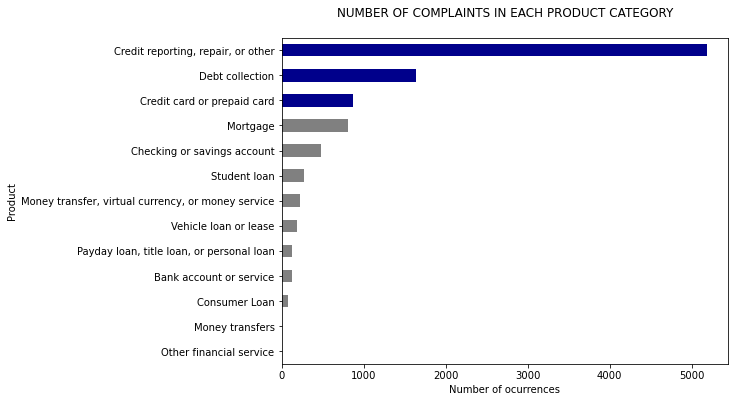

In [12]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey', 'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

### Text processing

In [13]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26360 features (TF-IDF score of unigrams and bigrams)


In [15]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Bank account or service:
  * Most Correlated Unigrams are: bank, passwords, overdraft
  * Most Correlated Bigrams are: overdraft fee, bank website, checking account


d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Checking or savings account:
  * Most Correlated Unigrams are: deposited, branch, checking
  * Most Correlated Bigrams are: savings account, wells fargo, checking account


d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Consumer Loan:
  * Most Correlated Unigrams are: ford, max, car
  * Most Correlated Bigrams are: car car, discrimination xxxx, fargo dealer


d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit card or prepaid card:
  * Most Correlated Unigrams are: visa, express, card
  * Most Correlated Bigrams are: card company, american express, credit card


d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: 1681, section, reporting
  * Most Correlated Bigrams are: credit report, 15 1681, 1681 section


d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: collection agency, debt collection, collect debt


d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Money transfer, virtual currency, or money service:
  * Most Correlated Unigrams are: crypto, paypal, coinbase
  * Most Correlated Bigrams are: coinbase account, western union, paypal account


d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Money transfers:
  * Most Correlated Unigrams are: relationships, bounce, google
  * Most Correlated Bigrams are: money left, paypal credit, money transfer


d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Mortgage:
  * Most Correlated Unigrams are: modification, escrow, mortgage
  * Most Correlated Bigrams are: loan modification, mortgage payment, mortgage company


d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Other financial service:
  * Most Correlated Unigrams are: ext, nationwide, doc
  * Most Correlated Bigrams are: communication received, public service, employed time


d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Payday loan, title loan, or personal loan:
  * Most Correlated Unigrams are: loan, borrowed, payday
  * Most Correlated Bigrams are: pay loan, payday loan, payday loans


d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Student loan:
  * Most Correlated Unigrams are: loans, student, navient
  * Most Correlated Bigrams are: student loans, loan forgiveness, student loan

==> Vehicle loan or lease:
  * Most Correlated Unigrams are: gap, vehicle, car
  * Most Correlated Bigrams are: purchased vehicle, auto loan, gap insurance


d:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Models

In [14]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

In [17]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

d:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lear

In [18]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8237,0.009271
LogisticRegression,0.7973,0.008636
MultinomialNB,0.6695,0.008352
RandomForestClassifier,0.5184,0.000418


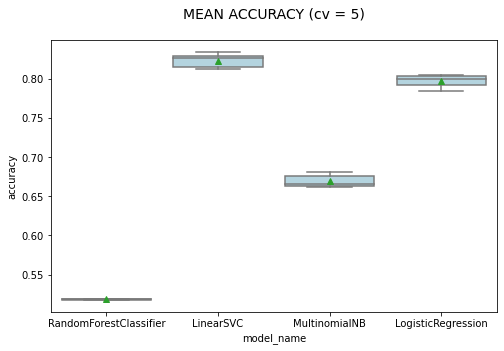

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [20]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df2.index, test_size=0.25, random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [21]:
df2['Product'].unique()

array(['Credit reporting, repair, or other', 'Vehicle loan or lease',
       'Bank account or service',
       'Payday loan, title loan, or personal loan', 'Student loan',
       'Credit card or prepaid card', 'Checking or savings account',
       'Debt collection', 'Mortgage',
       'Money transfer, virtual currency, or money service',
       'Consumer Loan', 'Money transfers', 'Other financial service'],
      dtype=object)

In [22]:
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

`precision = true positives / (true positives + false positives)`

Precision provides an indication of the model's ability to correctly classify positive instances. A high precision score indicates that the model is making very few false positive predictions, i.e., it is correctly identifying most of the positive instances, while a low precision score indicates that the model is making many false positive predictions.


`Recall = TP / (TP + FN)`

A high recall means that the model is good at finding all the positive samples, even if it means classifying some negative samples as positive (which could lower precision). A low recall means that the model is missing some positive samples.


`F1 score = 2 * (precision * recall) / (precision + recall)`

F1 score is the harmonic mean of precision and recall. It is a single metric that combines both precision and recall into a single value that represents the overall performance of a classification model.

The F1 score ranges from 0 to 1, where a score of 1 represents perfect precision and recall, and a score of 0 represents poor precision and recall. A high F1 score indicates that the model has a good balance between precision and recall, and is able to classify the positive and negative samples accurately.


`"support"` refers to the number of samples in each class of the true target labels (y_test) that are used to calculate the classification metrics such as precision, recall, and F1-score.

In [23]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, labels=np.unique(y_test)))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1300
           1       0.52      0.25      0.34        44
           2       0.60      0.09      0.16        33
           3       0.59      0.28      0.38        36
           4       0.90      0.73      0.81        85
           5       0.71      0.77      0.74       202
           6       0.69      0.75      0.72       122
           7       0.76      0.77      0.76       396
           8       0.89      0.95      0.92       203
           9       0.93      0.66      0.77        59
          10       0.50      0.05      0.09        20

    accuracy                           0.83      2500
   macro avg       0.72      0.57      0.60      2500
weighted avg       0.82      0.83      0.82      2500



In [24]:
# # Classification report
# print('\t\t\t\tCLASSIFICATIION METRICS\n')
# print(metrics.classification_report(y_test, y_pred, target_names= df2['Product'].unique()))

The diagonal elements of the matrix represent the number of correct predictions for each class, while the off-diagonal elements represent the misclassifications.

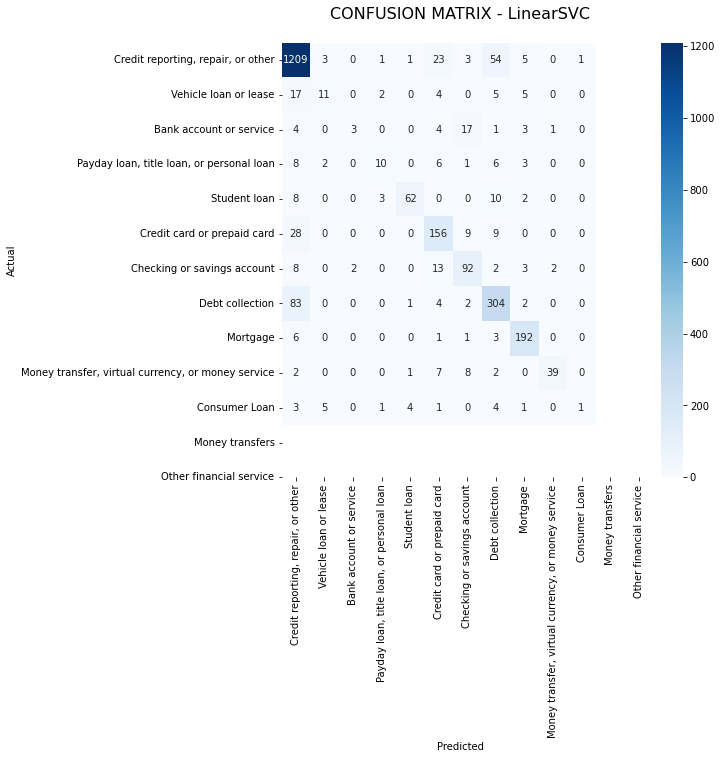

In [25]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [27]:
complaint = """I have received over 27 emails from XXXX XXXX who is a representative from Midland Funding LLC. 
From XX/XX/XXXX I received approximately 6 emails. From XX/XX/XXXX I received approximately 6 emails. 
From XX/XX/XXXX I received approximately 9 emails. From XX/XX/XXXX I received approximately 6 emails. 
All emails came from the same individual, XXXX XXXX. It is becoming a nonstop issue of harassment."""

print(model.predict(fitted_vectorizer.transform([complaint])))

['Debt collection']


In [28]:
complaint = """Respected Sir/ Madam, I am exploring the possibilities for financing my daughter 's 
XXXX education with private loan from bank. I am in the XXXX on XXXX visa. 
My daughter is on XXXX dependent visa. As a result, she is considered as international student. 
I am waiting in the Green Card ( Permanent Residency ) line for last several years. 

I checked with Discover, XXXX XXXX websites. While they allow international students to apply for loan, they need 
cosigners who are either US citizens or Permanent Residents. I feel that this is unfair. 
I had been given mortgage and car loans in the past which I closed successfully. I have good financial history. 
I think I should be allowed to remain cosigner on the student loan. I would be much obliged if you could look into it. 
Thanking you in advance. Best Regards"""

print(model.predict(fitted_vectorizer.transform([complaint])))

['Student loan']


In [29]:
complaint = """They make me look like if I was behind on my Mortgage on the month of XX/XX/2018 & XX/XX/XXXX 
when I was not and never was, when I was even giving extra money to the Principal. 
The Money Source Web site and the managers started a problem, when my wife was trying to increase the payment, 
so more money went to the Principal and two payments came out that month and because 
I reverse one of them thru my Bank as Fraud they took revenge and committed slander against me by reporting me late at the Credit Bureaus, 
for 45 and 60 days, when it was not thru. Told them to correct that and the accounting department or the company revert 
that letter from going to the Credit Bureaus to correct their injustice. The manager by the name XXXX requested this for 
the second time and nothing yet. I am a Senior of XXXX years old and a Retired XXXX Veteran and is a disgraced that Americans 
treat us that way and do not want to admit their injustice and lies to the Credit Bureau."""
print(model.predict(fitted_vectorizer.transform([complaint])))

['Mortgage']


In [16]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, labels, df2.index, test_size=0.25, random_state=1)

model = LogisticRegression()
model.fit(X_train, y_train)

# Generate predictions and calculate the probabilities for the testing set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

d:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


d:\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


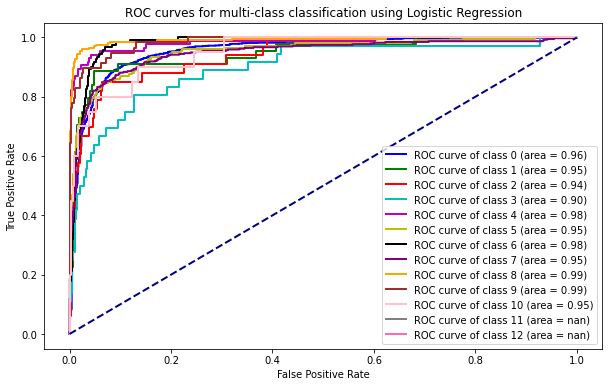

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression


probas = model.predict_proba(X_test)

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(model.classes_)
for i in range(n_classes):
    # Treat the current class as positive, and the rest as negative
    y_binary = (y_test == model.classes_[i])
    fpr[i], tpr[i], _ = roc_curve(y_binary, probas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'brown', 'pink', 'gray','hotpink' ]
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multi-class classification using Logistic Regression')
plt.legend(loc="lower right")
plt.show()